# Camera calibration with dome and without dome

In [217]:
import numpy as np
import cv2
import os
import glob
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm # notebook friendly progress bar
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import pickle


## Setup
Prepare image paths and checkerboard config

In [212]:
# image paths.
dataset_path = "./data"
image_dir_with_dome = os.path.join(dataset_path, "with_dome")
image_dir_no_dome = os.path.join(dataset_path, "no_dome")
img_ext = "jpg" # image file extension

image_paths_with_dome = glob.glob(image_dir_with_dome + "/*." + img_ext)
image_paths_no_dome = glob.glob(image_dir_no_dome + "/*." + img_ext)

scale = 0.5
output_path = "./results_scale_0.5"

# checkerboard config.
square_size = 0.025
chessboard_dims = [6, 9]

os.makedirs(output_path, exist_ok=True)

## Camera calibration part

In [213]:
# Show one image (OpenCV stores images different from Matplotlib)
def img_for_show(img, scale=0.25):
    img_dbg = cv2.cvtColor(
        cv2.resize(img,
                   dsize=(int(img.shape[1] * scale),
                          int(img.shape[0] * scale))), cv2.COLOR_BGR2RGB)
    return img_dbg


def plot_images(imgs,
                titles=None,
                cmaps='gray',
                dpi=100,
                pad=.5,
                adaptive=True):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
        adaptive: whether the figure size should fit the image aspect ratios.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n

    if adaptive:
        ratios = [i.shape[1] / i.shape[0] for i in imgs]  # W / H
    else:
        ratios = [4 / 3] * n
    figsize = [sum(ratios) * 4.5, 4.5]
    fig, ax = plt.subplots(1,
                           n,
                           figsize=figsize,
                           dpi=dpi,
                           gridspec_kw={'width_ratios': ratios})
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


# Draw chessboard corners:
def draw_points(img, points, color, shape, size, line_thickness):
    if len(img.shape) == 2:
        bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        bgr = img
    for point in points:
        if shape == "square":
            corner1 = (int(point[0, 0] - size), int(point[0, 1] - size))
            corner2 = (int(point[0, 0] + size), int(point[0, 1] - size))
            corner3 = (int(point[0, 0] + size), int(point[0, 1] + size))
            corner4 = (int(point[0, 0] - size), int(point[0, 1] + size))
            cv2.line(bgr, corner1, corner2, color, line_thickness)
            cv2.line(bgr, corner2, corner3, color, line_thickness)
            cv2.line(bgr, corner4, corner3, color, line_thickness)
            cv2.line(bgr, corner1, corner4, color, line_thickness)
        elif shape == "cross":
            cv2.line(bgr, (int(point[0, 0]), int(point[0, 1]) - size),
                     (int(point[0, 0]), int(point[0, 1] + size)), color,
                     line_thickness)
            cv2.line(bgr, (int(point[0, 0] - size), int(point[0, 1])),
                     (int(point[0, 0] + size), int(point[0, 1])), color,
                     line_thickness)
        else:
            print("ERROR: Unknow shape ", shape, " is not supported")
            return
    return bgr


# Extract checkerboard corners for one image
def extract_corners(img, chessboard_dims, scale=1.0):
    if scale == 1.0:
        img_scaled = img
    else:
        img_scaled = cv2.resize(img,
                                dsize=(int(img.shape[1] * scale),
                                       int(img.shape[0] * scale)))
    flags = None
    ret, corners = cv2.findChessboardCorners(img_scaled,
                                             chessboard_dims,
                                             flags=flags)
    if ret:

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30,
                    0.001)
        if len(img_scaled.shape) == 3:
            if img_scaled.shape[2] == 3:
                gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
        else:
            gray = img_scaled
        corners_sub = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                       criteria)
        return corners_sub
    else:
        return []


# Extract checkerboard corners for all images
def extract_corners_all(image_paths, chessboard_dims, scale=1.0):
    good_img_list = []
    corners_all = []

    for i, path in enumerate(tqdm.tqdm(image_paths)):
        print("Extracting chessboard corners for: ", os.path.basename(path))
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        corners = extract_corners(img, chessboard_dims, scale)
        if len(corners) == 0:
            print("WARN: Failed, checkerboard not found")
        else:
            print("Succeed! Found checkerboard", len(corners), " of points")
            good_img_list.append(i)
            corners_all.append(corners)
    return good_img_list, corners_all


def save_extracted_corners(image_file_names, good_image_list, corners_all,
                           output_path):
    data = {
        "image_file_names": image_file_names,
        "good_image_list": good_image_list,
        "corners_all": corners_all
    }
    with open(output_path, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_extracted_corners(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data["image_file_names"], data["good_image_list"], data[
        "corners_all"]


def calibrate_camera(corners, image_size, chessboard_dims, square_size):
    points3D = []
    for x in range(chessboard_dims[1]):
        for y in range(chessboard_dims[0]):
            points3D.append(
                np.array([float(x) * square_size,
                          float(y) * square_size, 0.0], np.float32))
    points3D = np.array(points3D)

    objpoints = []
    for i in range(len(corners)):
        objpoints.append(points3D)

    flags = cv2.CALIB_FIX_K5 + cv2.CALIB_FIX_K6
    ret, camera_matrix, distortion, rvecs, tvecs, std_intrinsic, std_extrinsic, _ = cv2.calibrateCameraExtended(
        objpoints,
        corners,
        image_size,
        None,
        None,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300,
                  1e-10))

    calib_stats = {
        "reprojection_error": ret,
        "camera_matrix": camera_matrix,
        "distortion": distortion,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "std_intrinsic": std_intrinsic,
        "std_extrinsic": std_extrinsic
    }
    return calib_stats


def report_calib_stats(calib_stats):
    print("Camera matrix definition\n")
    print("[[fx, 0, cx]\n [0, fy, cy]\n [0,  0,  1]]")
    print("Distortion coefficient definition\n")
    print("[[k1, k2, p1, p2, k3]]")
    print("===================================")
    print()

    camera_matrix_std = np.eye(3)
    camera_matrix_std[0, 0] = calib_stats["std_intrinsic"][0, 0]
    camera_matrix_std[1, 1] = calib_stats["std_intrinsic"][1, 0]
    camera_matrix_std[0, 2] = calib_stats["std_intrinsic"][2, 0]
    camera_matrix_std[1, 2] = calib_stats["std_intrinsic"][3, 0]
    distortion_std = np.zeros(shape=(1, 5))
    distortion_std[0, 0] = calib_stats["std_intrinsic"][4, 0]
    distortion_std[0, 1] = calib_stats["std_intrinsic"][5, 0]
    distortion_std[0, 2] = calib_stats["std_intrinsic"][6, 0]
    distortion_std[0, 3] = calib_stats["std_intrinsic"][7, 0]
    distortion_std[0, 4] = calib_stats["std_intrinsic"][8, 0]
    print("Calibration reprojection error\n",
          calib_stats["reprojection_error"])
    print("Camera matrix\n", calib_stats["camera_matrix"])
    print("Camera matrix uncertainty\n", camera_matrix_std)
    print("distortion\n", calib_stats["distortion"])
    print("distortion uncertainty\n", distortion_std)


def evaluate_reprojection(img,
                          camera_matrix,
                          distortion,
                          rvec,
                          tvec,
                          points2D,
                          chessboard_dims,
                          drawing_size=7,
                          line_thickness=3):
    points3D = []
    for x in range(chessboard_dims[1]):
        for y in range(chessboard_dims[0]):
            points3D.append(
                np.array([float(x) * square_size,
                          float(y) * square_size, 0.0], np.float32))
    points3D = np.array(points3D)

    reprojections, _ = cv2.projectPoints(points3D, rvec, tvec, camera_matrix,
                                         distortion)
    reprojection_errors = np.linalg.norm(reprojections - points2D, axis=2)

    draw_points(img,
                points2D, (0, 255, 0),
                shape="cross",
                size=drawing_size,
                line_thickness=line_thickness)
    draw_points(img,
                reprojections, (0, 0, 255),
                shape="square",
                size=drawing_size,
                line_thickness=line_thickness)
                
    return reprojections, reprojection_errors


## Calibration
First, we list a few images to look at

With dome port

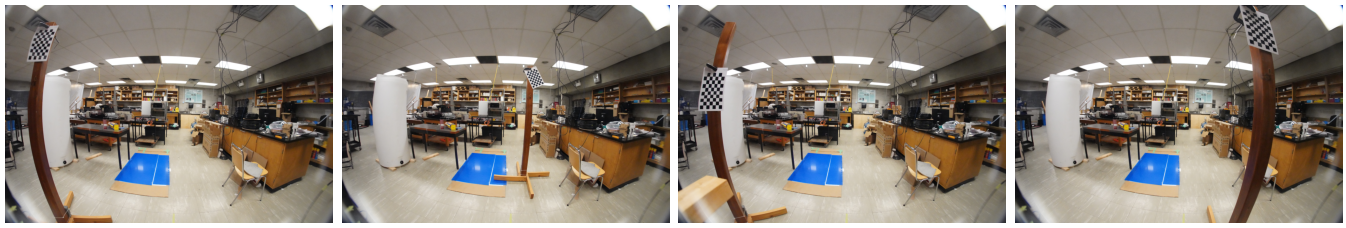

In [214]:
imgs_for_vis = random.choices(image_paths_with_dome, k=4)
imgs = []
for path in imgs_for_vis:
    imgs.append(img_for_show(cv2.imread(path, cv2.IMREAD_COLOR), scale=scale))
plot_images(imgs, dpi=50)
image_size = (imgs[0].shape[    1], imgs[0].shape[0])

Without dome

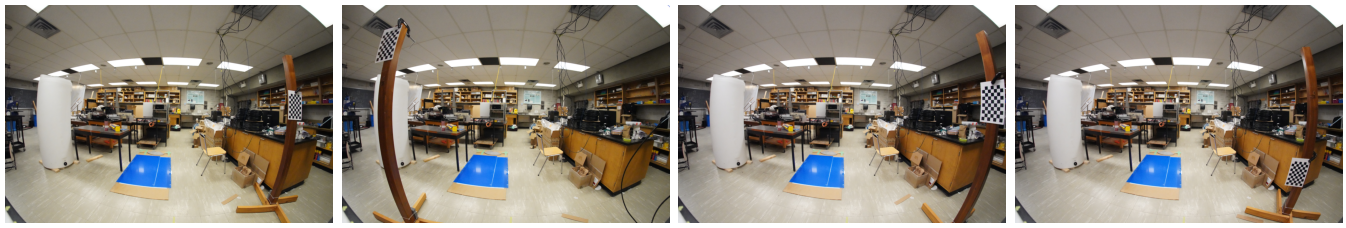

In [215]:
imgs_for_vis = random.choices(image_paths_no_dome, k=4)
imgs = []
for path in imgs_for_vis:
    imgs.append(img_for_show(cv2.imread(path, cv2.IMREAD_COLOR), scale=scale))
plot_images(imgs, dpi=50)

#### Extract corners

In [216]:
# Test corner extraction
print("====================================")
print("Extract corners for images with dome")
print("====================================")
good_images_with_dome, corners_all_with_dome = extract_corners_all(image_paths_with_dome, chessboard_dims, scale=scale)
print("=======================================")
print("Extract corners for images without dome")
print("=======================================")
good_images_no_dome, corners_all_no_dome = extract_corners_all(image_paths_no_dome, chessboard_dims, scale=scale)

path_to_extracted_data_with_dome = os.path.join(output_path, "corners_with_filenames_with_dome.pkl")
path_to_extracted_data_no_dome = os.path.join(output_path, "corners_with_filenames_no_dome.pkl")
save_extracted_corners(image_paths_with_dome, good_images_with_dome, corners_all_with_dome, path_to_extracted_data_with_dome)
save_extracted_corners(image_paths_no_dome, good_images_no_dome, corners_all_no_dome, path_to_extracted_data_no_dome)

Extract corners for images with dome


  0%|          | 0/25 [00:00<?, ?it/s]

Extracting chessboard corners for:  img1.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img10.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img11.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img12.jpg
WARN: Failed, checkerboard not found
Extracting chessboard corners for:  img13.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img14.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img15.jpg
WARN: Failed, checkerboard not found
Extracting chessboard corners for:  img16.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img17.jpg
WARN: Failed, checkerboard not found
Extracting chessboard corners for:  img18.jpg
WARN: Failed, checkerboard not found
Extracting chessboard corners for:  img19.jpg
WARN: Failed, checkerboard not found
Extracting chessboard corners for:  img2.jpg
Succeed! Foun

  0%|          | 0/25 [00:00<?, ?it/s]

Extracting chessboard corners for:  img26.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img27.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img28.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img29.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img30.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img31.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img32.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img33.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img34.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img35.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners for:  img36.jpg
Succeed! Found checkerboard 54  of points
Extracting chessboard corners fo

In [10]:
#### Evaluate corner extraction
print("With dome: ", len(good_images_with_dome), " / ",
      len(image_paths_with_dome), " images succeed")
print("No dome: ", len(good_images_no_dome), " / ", len(image_paths_no_dome),
      " images succeed")

# Draw corner detections
corner_output_path = os.path.join(output_path, "corners")
os.makedirs(os.path.join(corner_output_path, "with_dome"), exist_ok=True)
os.makedirs(os.path.join(corner_output_path, "no_dome"), exist_ok=True)

color = (0, 255, 0)
shape = "cross"
line_thick = 2
cross_size = 9

for i, idx in enumerate(good_images_with_dome):
    idx = good_images_with_dome[i]
    img = cv2.imread(image_paths_with_dome[idx], cv2.IMREAD_COLOR)
    if scale == 1.0:
        img_scaled = img
    else:
        img_scaled = cv2.resize(img,
                                dsize=(int(img.shape[1] * scale),
                                       int(img.shape[0] * scale)))
    img_scaled = draw_points(img_scaled,
                             corners_all_with_dome[i],
                             color=color,
                             shape=shape,
                             size=cross_size,
                             line_thickness=line_thick)
    cv2.imwrite(
        os.path.join(corner_output_path, "with_dome",
                     os.path.basename(image_paths_with_dome[idx])), img_scaled)

for i, idx in enumerate(good_images_no_dome):
    idx = good_images_no_dome[i]
    img = cv2.imread(image_paths_no_dome[idx], cv2.IMREAD_COLOR)
    if scale == 1.0:
        img_scaled = img
    else:
        img_scaled = cv2.resize(img,
                                dsize=(int(img.shape[1] * scale),
                                       int(img.shape[0] * scale)))
    img_scaled = draw_points(img_scaled,
                             corners_all_no_dome[i],
                             color=color,
                             shape=shape,
                             size=cross_size,
                             line_thickness=line_thick)
    cv2.imwrite(
        os.path.join(corner_output_path, "no_dome",
                     os.path.basename(image_paths_no_dome[idx])), img_scaled)

With dome:  18  /  25  images succeed
No dome:  25  /  25  images succeed


#### Inspect the extracted corners and remove bad photos (!! Important !!)
Altough OpenCV corner detector is able to extract checkerboard corners, the user is supposed to inspect whether those corners were extracted correctly.
And if the corners are wrongly detected, we should remove them from the image list

To remove a bad photo, find out the corresponding image index given by the image name, and add it to the list `photo_idxs_to_be_removed` in the next step

With dome:

In [8]:
print("=========================================")
print("With dome: image indices ---- image names")
print("=========================================")
for idx in good_images_with_dome:
    print(idx, " ---- ", os.path.basename(image_paths_with_dome[idx]))

With dome: image indices ---- image names
0  ----  img1.jpg
1  ----  img10.jpg
2  ----  img11.jpg
4  ----  img13.jpg
5  ----  img14.jpg
7  ----  img16.jpg
11  ----  img2.jpg
12  ----  img20.jpg
13  ----  img21.jpg
14  ----  img22.jpg
16  ----  img24.jpg
17  ----  img25.jpg
18  ----  img3.jpg
20  ----  img5.jpg
21  ----  img6.jpg
22  ----  img7.jpg
23  ----  img8.jpg
24  ----  img9.jpg


No Dome:

In [9]:
print("=========================================")
print("No dome: image indices ---- image names")
print("=========================================")
for idx in good_images_no_dome:
    print(idx, " ---- ", os.path.basename(image_paths_no_dome[idx]))


No dome: image indices ---- image names
0  ----  img26.jpg
1  ----  img27.jpg
2  ----  img28.jpg
3  ----  img29.jpg
4  ----  img30.jpg
5  ----  img31.jpg
6  ----  img32.jpg
7  ----  img33.jpg
8  ----  img34.jpg
9  ----  img35.jpg
10  ----  img36.jpg
11  ----  img37.jpg
12  ----  img38.jpg
13  ----  img39.jpg
14  ----  img40.jpg
15  ----  img41.jpg
16  ----  img42.jpg
17  ----  img43.jpg
18  ----  img44.jpg
19  ----  img45.jpg
20  ----  img46.jpg
21  ----  img47.jpg
22  ----  img48.jpg
23  ----  img49.jpg
24  ----  img50.jpg


In [11]:
photo_idxs_to_be_removed_with_dome = [13]
photo_idxs_to_be_removed_no_dome = [5, 8, 19, 20, 21]

print("With dome case: ")
photo_names_to_be_removed = []
for idx in photo_idxs_to_be_removed_with_dome:
    photo_names_to_be_removed.append(os.path.basename(image_paths_with_dome[idx]))
print("Removing photos: ", photo_names_to_be_removed)

print("No dome case: ")
photo_names_to_be_removed = []
for idx in photo_idxs_to_be_removed_no_dome:
    photo_names_to_be_removed.append(os.path.basename(image_paths_no_dome[idx]))
print("Removing photos: ", photo_names_to_be_removed)


With dome case: 
Removing photos:  ['img21.jpg']
No dome case: 
Removing photos:  ['img31.jpg', 'img34.jpg', 'img45.jpg', 'img46.jpg', 'img47.jpg']


#### Finally, do calibration

In [12]:
img_idxs_for_calib_with_dome = []
img_idxs_for_calib_no_dome = []

corners_all_filtered_with_dome = []
corners_all_filtered_no_dome = []

for i, idx in enumerate(good_images_with_dome):
    if idx in photo_idxs_to_be_removed_with_dome:
        continue
    img_idxs_for_calib_with_dome.append(idx)
    corners_all_filtered_with_dome.append(corners_all_with_dome[i])

for i, idx in enumerate(good_images_no_dome):
    if idx in photo_idxs_to_be_removed_no_dome:
        continue
    img_idxs_for_calib_no_dome.append(idx)
    corners_all_filtered_no_dome.append(corners_all_no_dome[i])

print("Number of images for calibration: With dome -- ",
      len(img_idxs_for_calib_with_dome), " , No dome -- ",
      len(img_idxs_for_calib_no_dome))

calib_stats_with_dome = calibrate_camera(corners_all_filtered_with_dome,
                                         image_size=image_size,
                                         chessboard_dims=chessboard_dims,
                                         square_size=square_size)
calib_stats_no_dome = calibrate_camera(corners_all_filtered_no_dome,
                                       image_size=image_size,
                                       chessboard_dims=chessboard_dims,
                                       square_size=square_size)

Number of images for calibration: With dome --  17  , No dome --  20


#### Evaluate camera calibration
With dome case

In [13]:
print("=========")
print("With dome")
print("=========")
report_calib_stats(calib_stats_with_dome)

With dome
Camera matrix definition

[[fx, 0, cx]
 [0, fy, cy]
 [0,  0,  1]]
Distortion coefficient definition

[[k1, k2, p1, p2, k3]]

Calibration reprojection error
 1.3862598311009888
Camera matrix
 [[1.03970742e+03 0.00000000e+00 1.10821375e+03]
 [0.00000000e+00 1.03570123e+03 7.62755054e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Camera matrix uncertainty
 [[48.81710099  0.          8.60158591]
 [ 0.         47.69796908 13.04931405]
 [ 0.          0.          1.        ]]
distortion
 [[-0.28563899  0.07781394  0.00690267  0.00125247 -0.00901527]]
distortion uncertainty
 [[0.02928698 0.01772367 0.00113493 0.00082897 0.00318607]]


No dome case

In [14]:
print("=========")
print("No dome")
print("=========")
report_calib_stats(calib_stats_no_dome)

No dome
Camera matrix definition

[[fx, 0, cx]
 [0, fy, cy]
 [0,  0,  1]]
Distortion coefficient definition

[[k1, k2, p1, p2, k3]]

Calibration reprojection error
 0.5910822396872909
Camera matrix
 [[1.11843491e+03 0.00000000e+00 1.16146446e+03]
 [0.00000000e+00 1.11908341e+03 8.20187936e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Camera matrix uncertainty
 [[27.02509408  0.          5.47876675]
 [ 0.         26.81852703  5.60330715]
 [ 0.          0.          1.        ]]
distortion
 [[-0.30603249  0.09147803  0.00173112  0.00252691 -0.01126386]]
distortion uncertainty
 [[0.01773889 0.01090338 0.00049795 0.0005365  0.0019823 ]]


Show reprojections

In [74]:
# With dome

reproj_output_path = os.path.join(output_path, "reprojections")
os.makedirs(os.path.join(reproj_output_path, "with_dome"), exist_ok=True)
os.makedirs(os.path.join(reproj_output_path, "no_dome"), exist_ok=True)

reprojections_with_dome = []
reprojections_no_dome = []
reprojection_errors_with_dome = []
reprojection_errors_no_dome = []

print("Evaluating reprojections -- With dome")
for i, idx in enumerate(tqdm.tqdm(img_idxs_for_calib_with_dome)):
    img = cv2.imread(image_paths_with_dome[idx])
    img = cv2.resize(img,
                     dsize=(int(img.shape[1] * scale),
                            int(img.shape[0] * scale)))
    rvec = calib_stats_with_dome["rvecs"][i]
    tvec = calib_stats_with_dome["tvecs"][i]
    cam_matrix = calib_stats_with_dome["camera_matrix"]
    dist = calib_stats_with_dome["distortion"]
    reproj, errs = evaluate_reprojection(img, cam_matrix, dist, rvec, tvec,
                                         corners_all_filtered_with_dome[i],
                                         chessboard_dims, cross_size,
                                         line_thick)
    reprojections_with_dome.append(reproj)
    reprojection_errors_with_dome.append(errs)
    cv2.imwrite(
        os.path.join(reproj_output_path, "with_dome",
                     os.path.basename(image_paths_with_dome[idx])), img)

print("Evaluating reprojections -- No dome")
for i, idx in enumerate(tqdm.tqdm(img_idxs_for_calib_no_dome)):
    img = cv2.imread(image_paths_no_dome[idx])
    img = cv2.resize(img,
                     dsize=(int(img.shape[1] * scale),
                            int(img.shape[0] * scale)))
    rvec = calib_stats_no_dome["rvecs"][i]
    tvec = calib_stats_no_dome["tvecs"][i]
    cam_matrix = calib_stats_no_dome["camera_matrix"]
    dist = calib_stats_no_dome["distortion"]
    reporj, errs = evaluate_reprojection(img, cam_matrix, dist, rvec, tvec,
                                         corners_all_filtered_no_dome[i],
                                         chessboard_dims, cross_size,
                                         line_thick)
    reprojections_no_dome.append(reproj)
    reprojection_errors_no_dome.append(errs)
    cv2.imwrite(
        os.path.join(reproj_output_path, "no_dome",
                     os.path.basename(image_paths_no_dome[idx])), img)


Evaluating reprojections -- With dome


  0%|          | 0/17 [00:00<?, ?it/s]

Evaluating reprojections -- No dome


  0%|          | 0/20 [00:00<?, ?it/s]

Show sample reprojection images -- With dome
Show sample reprojection images -- No dome


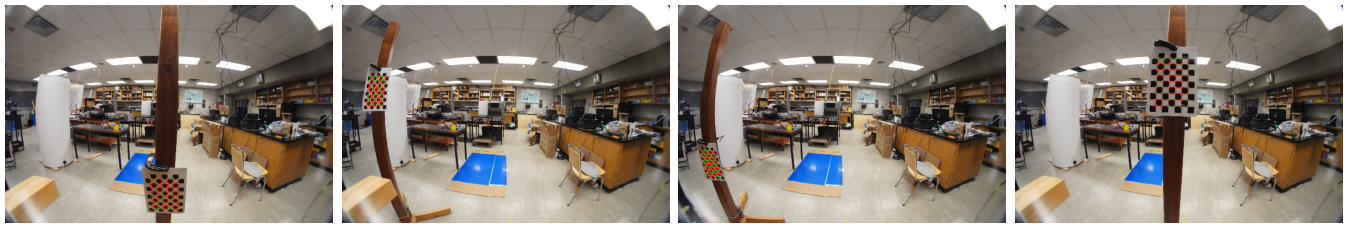

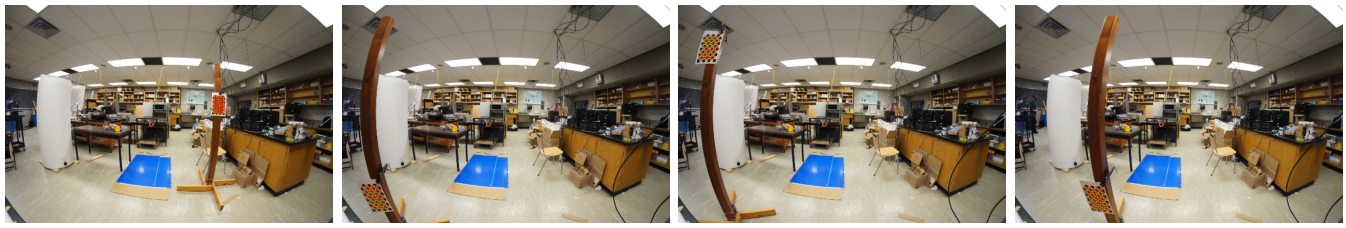

In [75]:
print("Show sample reprojection images -- With dome")
imgs_for_vis = random.choices(img_idxs_for_calib_with_dome, k=4)
imgs = []
for idx in imgs_for_vis:
    path = os.path.join(reproj_output_path, "with_dome",
                        os.path.basename(image_paths_with_dome[idx]))
    imgs.append(img_for_show(cv2.imread(path, cv2.IMREAD_COLOR), scale=scale))
plot_images(imgs, dpi=50)

print("Show sample reprojection images -- No dome")
imgs_for_vis = random.choices(img_idxs_for_calib_no_dome, k=4)
imgs = []
for idx in imgs_for_vis:
    path = os.path.join(reproj_output_path, "no_dome",
                        os.path.basename(image_paths_no_dome[idx]))
    imgs.append(img_for_show(cv2.imread(path, cv2.IMREAD_COLOR), scale=scale))
plot_images(imgs, dpi=50)

#### Evaluate points distribution and reprojection error distribution

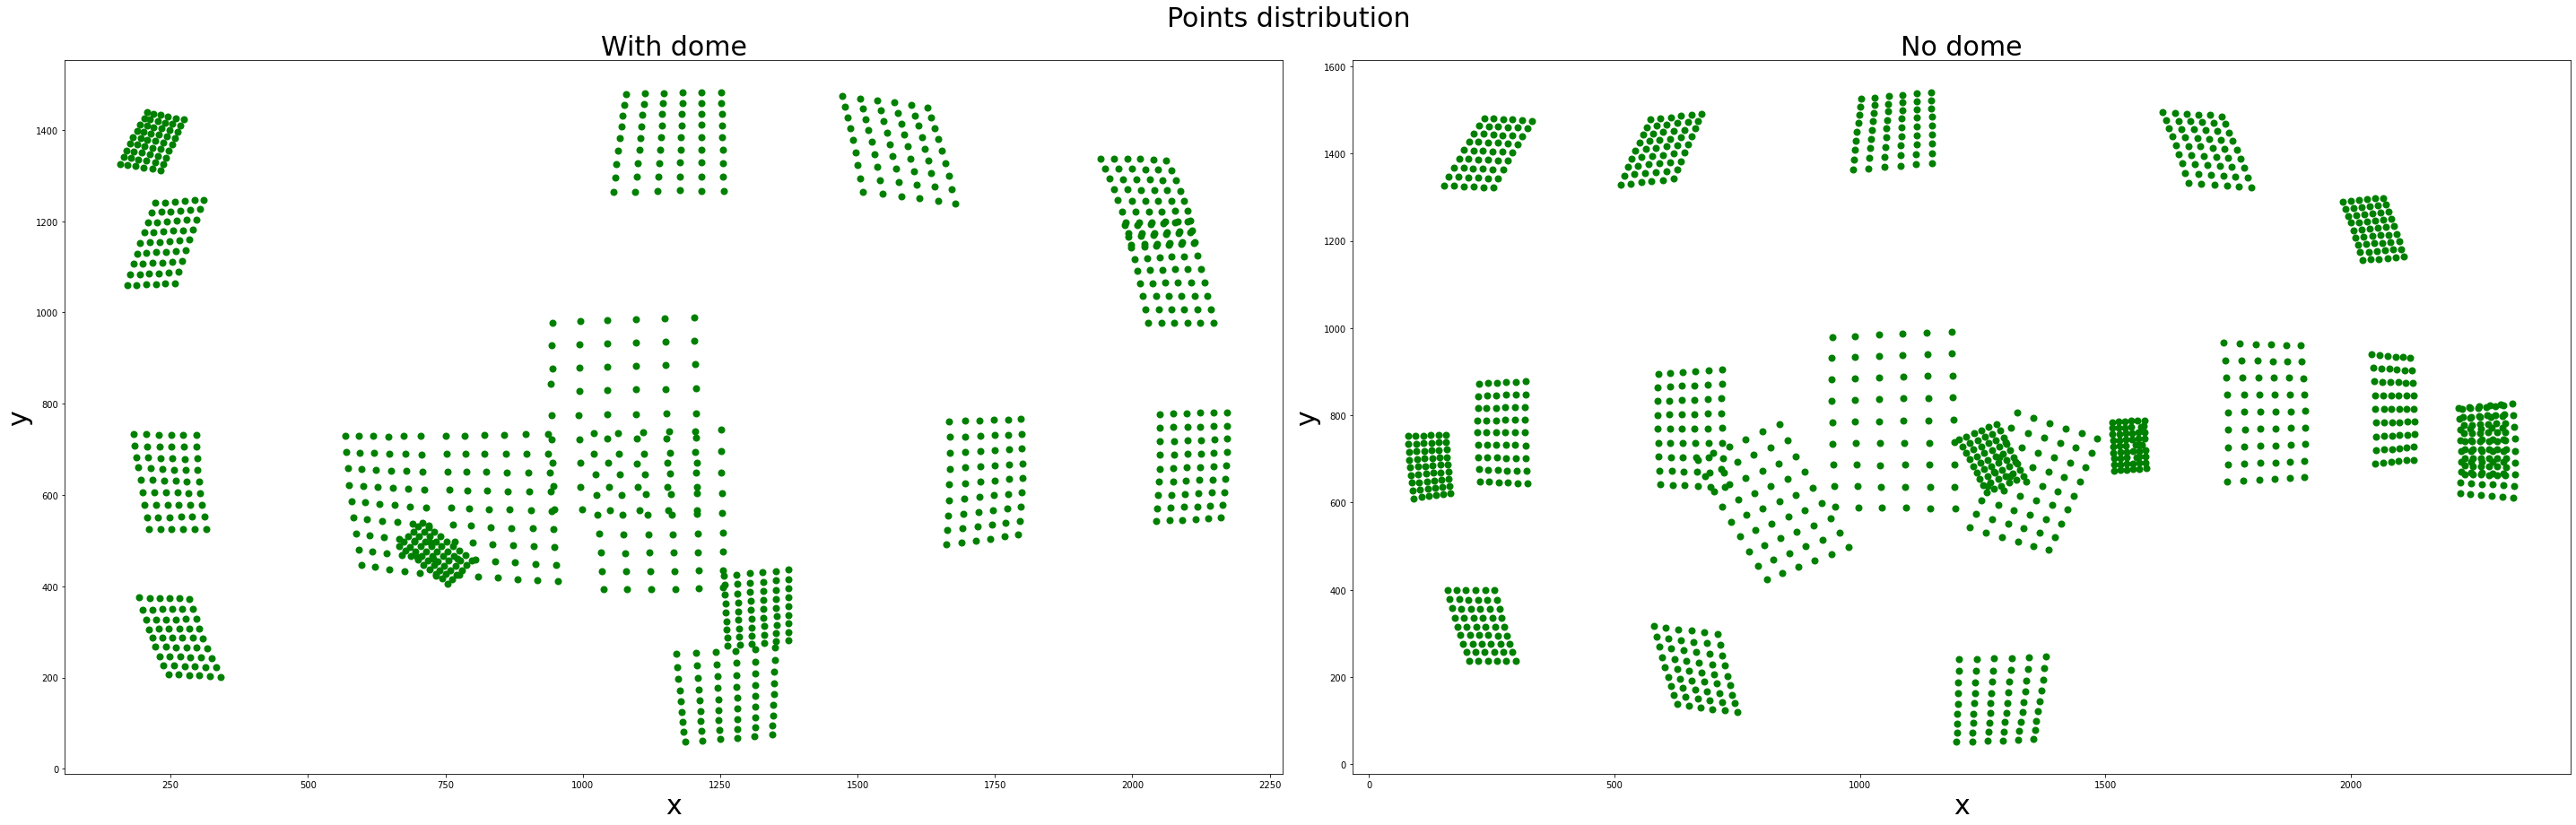

In [207]:
points2D_with_dome = np.array(corners_all_filtered_with_dome)
points2D_with_dome = points2D_with_dome.reshape(
    points2D_with_dome.shape[0] * points2D_with_dome.shape[1], 2)
points2D_no_dome = np.array(corners_all_filtered_no_dome)
points2D_no_dome = points2D_no_dome.reshape(
    points2D_no_dome.shape[0] * points2D_no_dome.shape[1], 2)

figwidth = 20
figheight = int(figwidth / 1.5)
fontsize = 30

fig, ax = plt.subplots(1, 2, figsize=(figwidth * 2, figheight))

fig.suptitle("Points distribution", fontsize=fontsize)


ax[0].scatter(points2D_with_dome[:, 0], points2D_with_dome[:, 1], color='g', linewidth=2)
ax[0].set_xlabel('x', fontsize=fontsize)
ax[0].set_ylabel('y', fontsize=fontsize)
ax[0].set_title('With dome', fontsize=fontsize)

ax[1].scatter(points2D_no_dome[:, 0], points2D_no_dome[:, 1], color='g', linewidth=2)
ax[1].set_xlabel('x', fontsize=fontsize)
ax[1].set_ylabel('y', fontsize=fontsize)
ax[1].set_title('No dome', fontsize=fontsize)

fig.tight_layout()
fig.savefig(os.path.join(output_path, "points_distribution.pdf"))
plt.show()


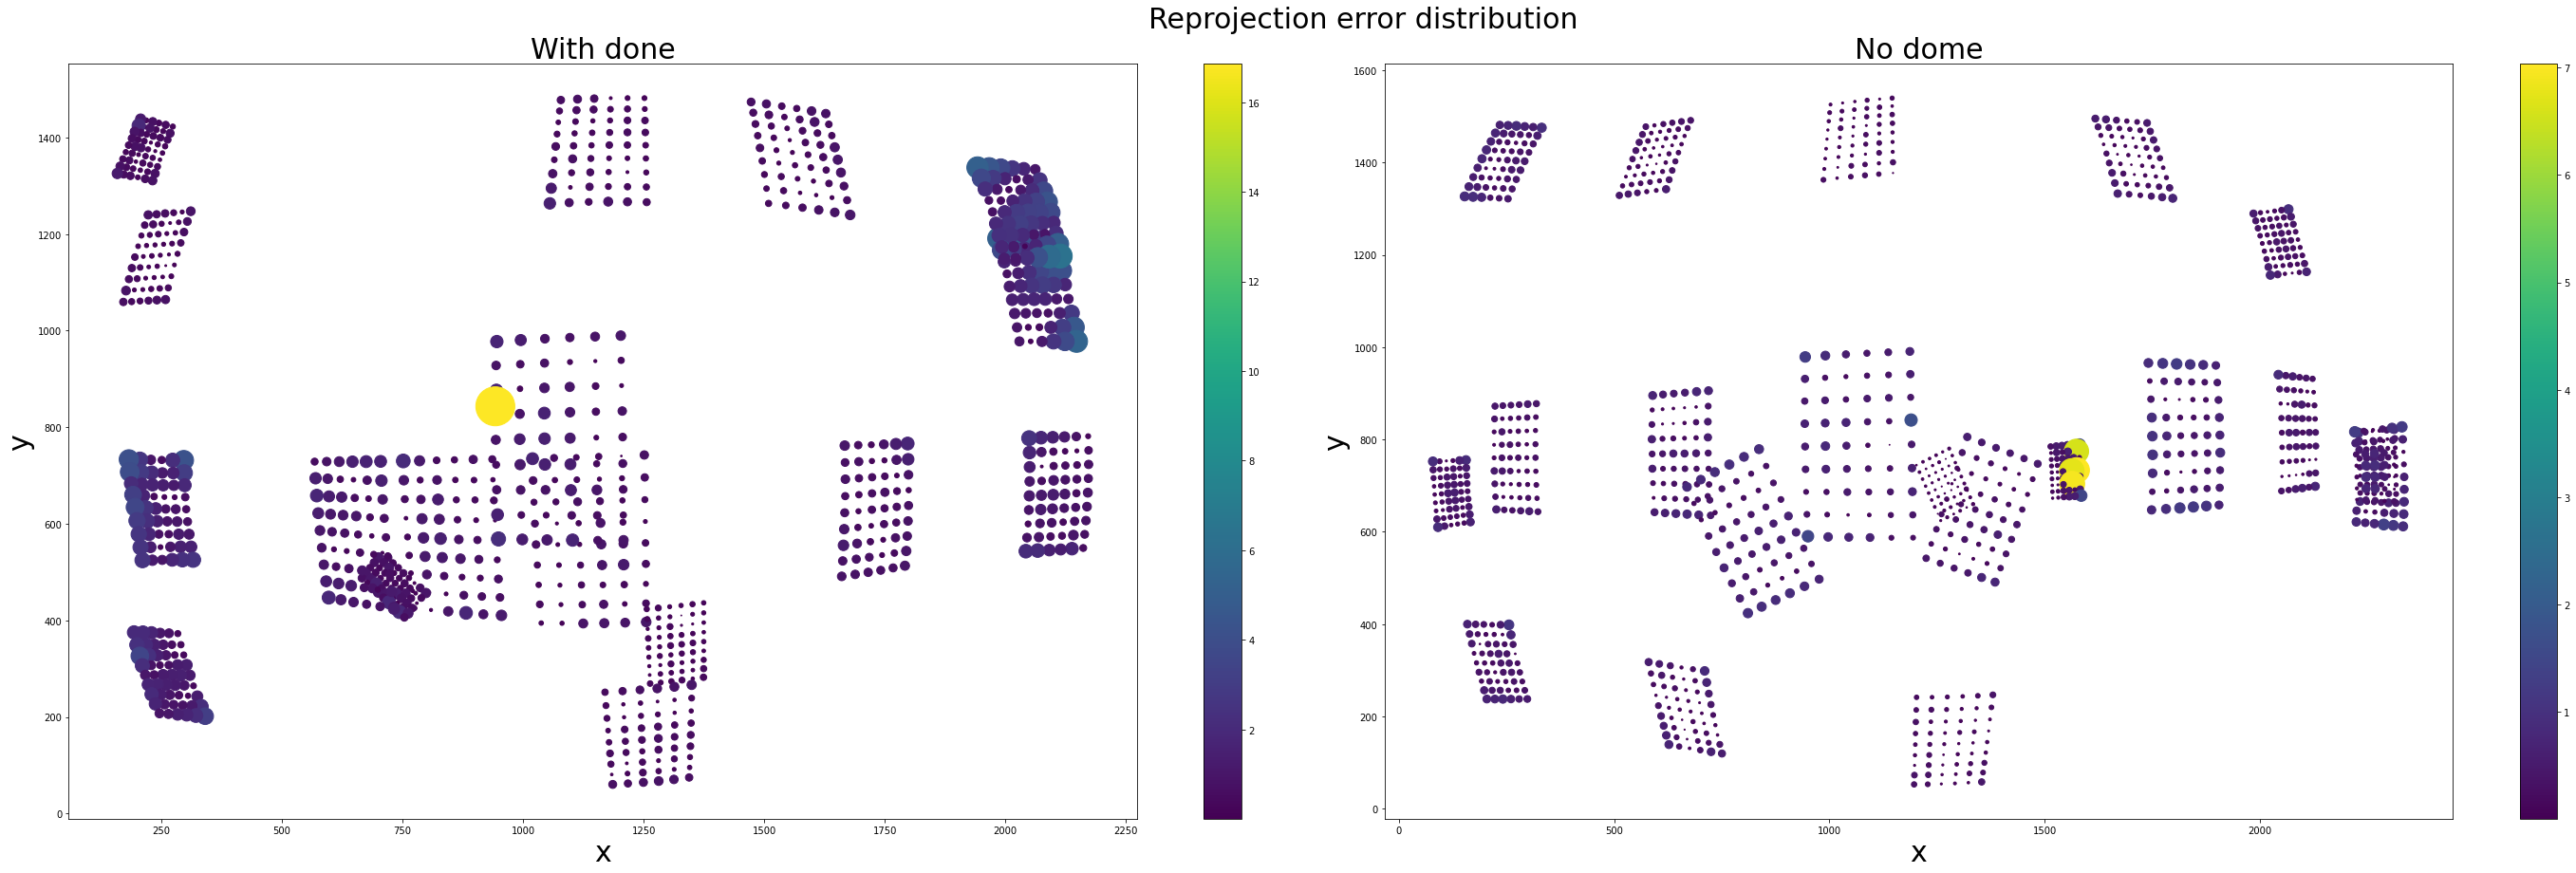

In [209]:
errors_with_dome = np.array(reprojection_errors_with_dome)
errors_with_dome = errors_with_dome.reshape(
    errors_with_dome.shape[0] * errors_with_dome.shape[1], -1)
errors_no_dome = np.array(reprojection_errors_no_dome)
errors_no_dome = errors_no_dome.reshape(
    errors_no_dome.shape[0] * errors_no_dome.shape[1], -1)

fig, ax = plt.subplots(1, 2, figsize=(figwidth * 2, figheight))

fig.suptitle("Reprojection error distribution", fontsize=fontsize)

cmap = "viridis"
cnorm_with_dome = mpl.colors.Normalize(vmin=np.min(errors_with_dome),
                                       vmax=np.max(errors_with_dome))
cnorm_no_dome = mpl.colors.Normalize(vmin=np.min(errors_no_dome),
                                     vmax=np.max(errors_no_dome))

ax[0].set_title("With dome", fontsize=fontsize)
ax[0].scatter(points2D_with_dome[:, 0],
              points2D_with_dome[:, 1],
              c=errors_with_dome,
              cmap='viridis',
              s=errors_with_dome * 100)
ax[0].set_xlabel('x', fontsize=fontsize)
ax[0].set_ylabel('y', fontsize=fontsize)
fig.colorbar(cm.ScalarMappable(norm=cnorm_with_dome, cmap=cmap), ax=ax[0])

ax[1].set_title("No dome", fontsize=fontsize)
ax[1].scatter(points2D_no_dome[:, 0],
              points2D_no_dome[:, 1],
              c=errors_no_dome,
              cmap='viridis',
              s=errors_no_dome * 100)
ax[1].set_xlabel('x', fontsize=fontsize)
ax[1].set_ylabel('y', fontsize=fontsize)
fig.colorbar(cm.ScalarMappable(norm=cnorm_no_dome, cmap=cmap), ax=ax[1])

fig.tight_layout()
fig.savefig(os.path.join(output_path, "reprojection_error_distribution.pdf"))
plt.show()